<a href="INSERT_colab_R_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

label: exercise
# Exercise 1 (d)

Implement the GP with squared exponential kernel, zero mean function and $\ell = 1$ from scratch for $n=2$ observations $(\bm{y},\bm{x})$. 
Do this as efficiently as possible by explicitly calculating all expensive computations by hand. Do the same for the posterior predictive distribution of $y_*$. Test your implementation using simulated data.


label: math_solution
# Solution: Explicit Calculations

To implement a GP with squared exponential kernel and $\ell = 1$, we need the inverse of $\bm{K}$. $\bm{x}$ being a vector implies that we have only one feature and thus the entries of our matrix $\bm{K}$ are 
$$
\bm{K} = \begin{pmatrix} 1 & \exp(-0.5 (x^{(1)} - x^{(2)})^2) \\ \exp(-0.5 (x^{(2)} - x^{(1)})^2) & 1 \end{pmatrix}.
$$

The inverse of $\bm{K}$ is then given by:
$$
\frac{1}{1-\exp(-(x^{(1)} - x^{(2)})^2)} \begin{pmatrix} 1 & -\exp(-0.5 (x^{(1)} - x^{(2)})^2) \\ -\exp(-0.5 (x^{(2)} - x^{(1)})^2) & 1 \end{pmatrix}.
$$

If we have a noisy GP, we would have to add $\sigma^2 \bm{I}_2$ to $\bm{K}$ with resulting inverse:

$$
\bm{K}_y^{-1} = \frac{1}{(1+\sigma^2)^2-\exp(-(x^{(1)} - x^{(2)})^2)} \begin{pmatrix} 1+\sigma^2 & -\exp(-0.5 (x^{(1)} - x^{(2)})^2) \\ -\exp(-0.5 (x^{(2)} - x^{(1)})^2) & 1+\sigma^2 \end{pmatrix}.
$$


Assuming a zero mean GP, we can derive $\frac{\partial \bm{K}_y}{\partial \theta}$ with $\theta = \sigma^2$, which gives us the identity matrix. We can thus maximize the marginal likelihood (slide on [*Gaussian Process Training*](https://slds-lmu.github.io/i2ml/chapters/19_gaussian_processes/19-05-training/)), by finding $\sigma^2$ that yields:
$$\text{tr}\left( \bm{K}_y^{-1} \bm{y} \bm{y}^\top \bm{K}_y^{-1} - \bm{K}_y^{-1} \right) = 0.$$

This can be solved analytically (though quite tedious). We will use a root-finding function for this. For the posterior predictive distribution we can make use of the results from the previous exercise.

label: setup
# Code Setup

In [35]:
#| label: setup

# you may need to install the kernlab package first
# install.packages("kernlab")
library(kernlab)

# set seed, define n, true (unknown) sigma
set.seed(4212)
n = 2
sigma = 1

label: kernel_setup
# Kernel Function Definition

We define the squared exponential kernel functions with length scale $l = 1$.

In [36]:
#| label: kernel-functions

# define kernel with l = 1
kernel_fun <- function(x) 
  kernelMatrix(kernel = rbfdot(sigma = 1/2), 
               x = x)
               
kernel_fun_pred <- function(x,y)
  kernelMatrix(kernel = rbfdot(sigma = 1/2), 
               x = x, y = y)

label: data_gen
## Data Generation

We generate synthetic data according to the GP generating process. First, we sample input points $x$, then construct the kernel matrix $K$ and add noise to get $K_y$, and finally sample observations $y$ from the multivariate normal distribution.

In [37]:
#| label: data_gen

# draw data according to the generating process:
x = rnorm(n)
K = kernel_fun(x)
K_y = K + diag(rep(sigma^2,2)) # adding noise

y = t(mvtnorm::rmvnorm(1, sigma = K_y)) # sampling from multiviate normal
print(y)

         [,1]
[1,] 2.012317
[2,] 1.866819


label: hyperparameter-optimization-explanation
# Hyperparameter Optimization

We implement the root-finding function to optimize the noise parameter $\sigma^2$ by setting the derivative of the marginal likelihood to zero. This corresponds to finding the root of the trace expression derived earlier.

In [38]:
#| label: optimize-hyperparameters

# function to find the best sigma^2
root_fun <- function(sigma_square){
  K_y_inv = solve(K + diag(rep(sigma_square, 2)))
  
  0.5 * sum(diag(K_y_inv %*% y %*% t(y) %*% K_y_inv - K_y_inv))
}

# get the best sigma
best_sigma_squared = uniroot(f = root_fun, interval = c(0,20))$root
print(best_sigma_squared)

[1] 1.943684


label: optim_visualization
## Visualization of Optimization

We plot the marginal likelihood derivative as a function of $\sigma^2$ to visualize the optimization problem and show where the optimal value is found (where the derivative equals zero).

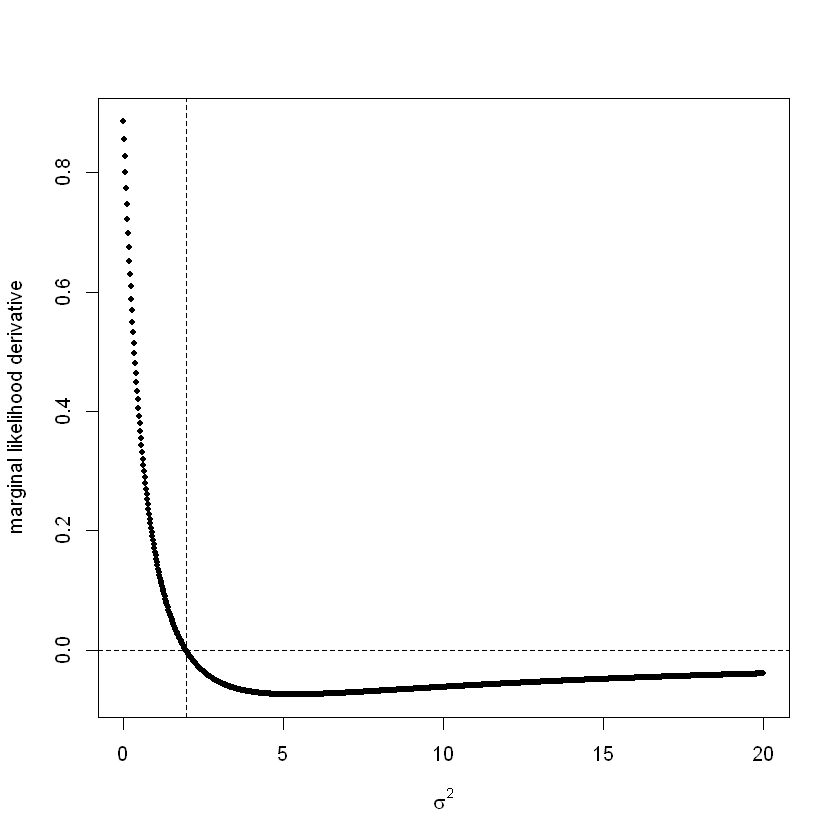

In [28]:
#| label: plot-optimization

# plot the optimization problem and best sigma
possible_sigma_vals <- seq(0.001, 20, l=1000)

plot(possible_sigma_vals, sapply(possible_sigma_vals, root_fun),
     xlab = expression(sigma^2), ylab = "marginal likelihood derivative",
     pch = 20)
    
abline(h=0, lty=2)
abline(v=best_sigma_squared, lty=2) # derivative = 0 at best sigma

label: posterior_predictiev
# Posterior Predictive Distribution

We implement a function to draw samples from the posterior predictive distribution. This uses the GP posterior mean and variance formulas to generate predictions at new input points $x^*$.

In [39]:
#| label: posterior-predictive-function

# function to draw samples from the predictive posterior
draw_from_pred_posterior <- function(number_samples, y, x, xstar, sigma_square=1)
{
  # invert noisy K
  K_y_inv = solve(kernel_fun(x) + diag(rep(sigma_square,2)))
  # get the other K's for new data
  Kstar = kernel_fun_pred(x,xstar)
  Kstarstar = kernel_fun(xstar)
  # draw samples according to Ex. (d)
  rnorm(number_samples, 
        mean = as.numeric(t(Kstar) %*% K_y_inv %*% y), 
        sd = sqrt(as.numeric(Kstarstar - t(Kstar) %*% K_y_inv %*% Kstar))
  )
  
}

label: sampling_visualization
## Sampling and Visualization

Finally, we draw samples from the posterior predictive distribution at a test point $x^* = 0$ using the optimized noise parameter, and visualize the distribution with a histogram.

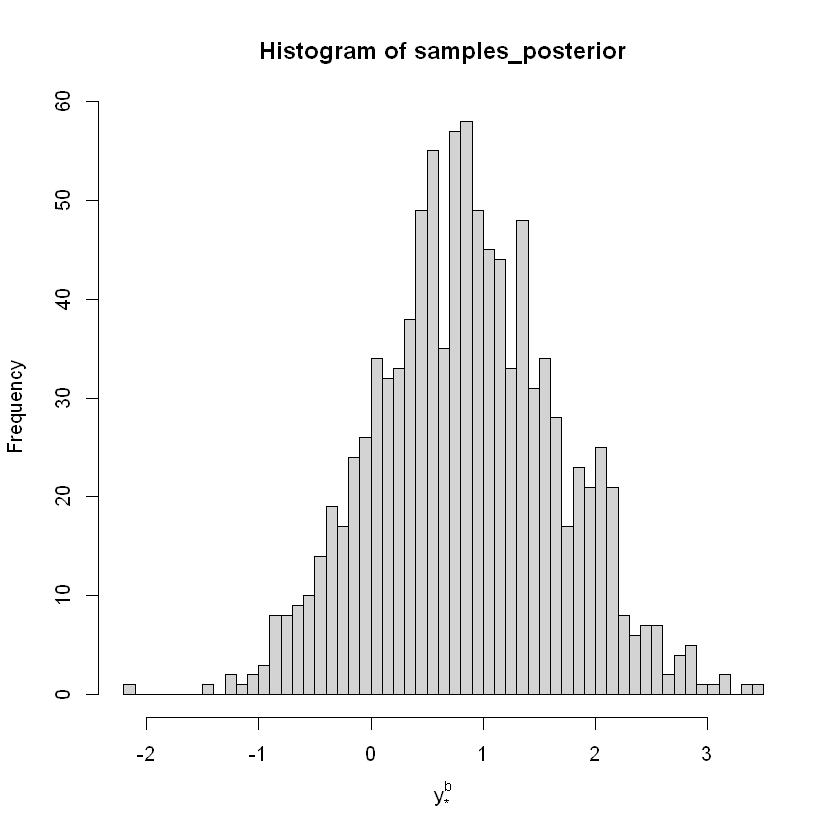

In [40]:
#| label: sample_and_plot

# draw enough samples to get a feeling for the distribution
samples_posterior = draw_from_pred_posterior(number_samples = 1000, 
                                             sigma_square = best_sigma_squared, 
                                             y = y, x = x, xstar = 0)
# plot the distribution
hist(samples_posterior, breaks=50, xlab=expression(y["*"]^b))